# Getting started for the AML 2023/2024 Egocentric Vision Project

<a href="https://colab.research.google.com/github/EgovisionPolito/aml23-ego/blob/master/colab_runner.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Downloading the code

In [ ]:
# Clone the public repository (or your repository)
!git clone https://github.com/FestaShabani/aml23-ego.git aml23-ego

Cloning into 'aml23-ego'...
remote: Enumerating objects: 548, done.
remote: Counting objects: 100% (260/260), done.
remote: Compressing objects: 100% (116/116), done.
remote: Total 548 (delta 162), reused 237 (delta 144), pack-reused 288
Receiving objects: 100% (548/548), 664.47 MiB | 22.29 MiB/s, done.
Resolving deltas: 100% (303/303), done.
Updating files: 100% (80/80), done.


In [ ]:
# Installing missing dependencies
!pip install omegaconf coloredlogs wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 30.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 13.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 13.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 27.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.6/289.6 kB 37.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 9.9 MB/s eta 0:00:00
  Created wheel for antlr4-python3-runtime: filename=antlr4_python3_runtime-4.9.3-py3-none-any.whl size=144554 sha256=d8ac5b20a567003c1810d184cbb4bdf39db4beb8b5f7417aba4fdf3c9d0a39cd
  Stored in directory: /root/.cache/pip/wheels/12/93/dd/1f6a127edc45659556564c5730f6d4e300888f4bca2d4c5a88
Successfully built a

## ACTION NET dataset

# pre-processing EMG

In [ ]:
# Mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%%bash

mkdir -p ./an_data/EMG
mkdir -p ./an_data/EMG_preprocessed #used later
cp -r "./drive/MyDrive/ActionNet-EMG/"* ./an_data/EMG/

In [ ]:
import numpy as np
from scipy import interpolate # for resampling
from scipy.signal import butter, lfilter # for filtering
import pandas as pd
from matplotlib import pyplot as plt
import pickle
from collections import OrderedDict
import os, glob

def load_data(filename):
    emg_data = pd.read_pickle(f"./an_data/EMG/{filename}")
    return emg_data

def data_loader(emg_ann):
    '''
    Retrieve data from emg_annotations file (train or test).
    Then it loads each experiment in the dictionary 'data_bySubject'
    starting from their header:

    `['index', 'file', 'description', 'labels']`

    data_bySubject[subject_id][video] contains the entire dataframe for
    that specific experiment, whom have the following header:

    `['description', 'start', 'stop', 'myo_left_timestamps', 'myo_left_readings',
    'myo_right_timestamps', 'myo_right_readings']`

    '''
    #['index', 'file', 'description', 'labels']
    #print(data_bySubject)

    distinct_files = list(map(lambda x: x.split('.')[0].split('_'), emg_ann['file'].unique()))
    final_df = pd.DataFrame()

    for file in distinct_files:
        subject_id, video = file
        file_name = f'{subject_id}_{video}.pkl'

        df_curr_file = emg_ann.query(f"file == '{file_name}'")

        indexes = list(df_curr_file['index'])
        data_byKey = load_data(file_name).loc[indexes] #get data of subject and id
        data_byKey['subject_id']=subject_id
        data_byKey['video']=video

        final_df = pd.concat([final_df, data_byKey], ignore_index=True)

    return final_df

def lowpass_filter(data, cutoff, Fs, order=5):
  nyq = 0.5 * Fs
  normal_cutoff = cutoff / nyq
  b, a = butter(order, normal_cutoff, btype='low', analog=False)
  y = lfilter(b, a, data.T).T
  return y


In [ ]:
activities_to_classify = [
  'Get/replace items from refrigerator/cabinets/drawers',
  'Peel a cucumber',
  'Clear cutting board',
  'Slice a cucumber',
  'Peel a potato',
  'Slice a potato',
  'Slice bread',
  'Spread almond butter on a bread slice',
  'Spread jelly on a bread slice',
  'Open/close a jar of almond butter',
  'Pour water from a pitcher into a glass',
  'Clean a plate with a sponge',
  'Clean a plate with a towel',
  'Clean a pan with a sponge',
  'Clean a pan with a towel',
  'Get items from cabinets: 3 each large/small plates, bowls, mugs, glasses, sets of utensils',
  'Set table: 3 each large/small plates, bowls, mugs, glasses, sets of utensils',
  'Stack on table: 3 each large/small plates, bowls',
  'Load dishwasher: 3 each large/small plates, bowls, mugs, glasses, sets of utensils',
  'Unload dishwasher: 3 each large/small plates, bowls, mugs, glasses, sets of utensils',
  ]

activities_renamed = {
    'Open a jar of almond butter' : 'Open/close a jar of almond butter',
    'Get items from refrigerator/cabinets/drawers' : 'Get/replace items from refrigerator/cabinets/drawers'
}

splits = ['train', 'test']
channels_min_max = {}
resampled_Fs = 10 # define rate for all sensors to interpolate
segment_duration_s = 10
save_dir = './EMG_preprocessed'

for split in splits:
  print(split)
  emg_annotations = pd.read_pickle(f'./aml23-ego/action-net/ActionNet_{split}.pkl')
  emg = data_loader(emg_annotations)

  #apply filtering
  for key in ['myo_right', 'myo_left']:
    for i, _ in emg.iterrows():
        data = abs(emg.loc[i, key + '_readings'])
        t =  emg.loc[i, key + '_timestamps']
        Fs = (t.size -1) / (t[-1] - t[0]) #number reading/total time = frequency (roughly 160)
        y =  lowpass_filter(data, 5, Fs)
        emg.at[i, key + '_readings'] = y

  #for each channel we have to compute min and max value for normalizing
  #we have 8 channel for each arm
  ##NB: for the test split compute channels_min_max with the training set and use same the values for the test split
  if split == 'train':
    for key in ['myo_right', 'myo_left']:
      channels = emg[key + '_readings'].apply(np.array)
      channels_min_max[key] = {'max': np.max(np.vstack(channels), axis=0), 'min': np.min(np.vstack(channels), axis=0)}

  #apply normalization
  for key in ['myo_right', 'myo_left']:
    for i, _ in emg.iterrows():
        data = emg.loc[i, key + '_readings']
        # Normalization
        data = 2 * (data - channels_min_max[key]['min']) / (channels_min_max[key]['max'] - channels_min_max[key]['min']) - 1
        emg.at[i, key + '_readings'] = data

  #DOWNSAMPLING
  #each sensor captured data at roughly 160hz.
  #this is too much data that will overload our model so we apply downsampling
  for key in ['myo_right', 'myo_left']:
      for i, _ in emg.iterrows():
          original_data = np.squeeze(np.array(emg.loc[i, f'{key}_readings']))
          time_s = np.squeeze(np.array(emg.loc[i, f'{key}_timestamps']))

          target_time_s = np.linspace(time_s[0], time_s[-1],
                                          num=int(round(1+resampled_Fs*(time_s[-1] - time_s[0]))), #resampled_Fs hz * seconds of segment
                                          endpoint=True)
          #using interpolate to extract the data
          fn_interpolate = interpolate.interp1d(
                  time_s,
                  original_data,
                  axis=0,
                  fill_value='extrapolate'
              )

          data_resampled = fn_interpolate(target_time_s)

          if np.any(np.isnan(data_resampled)):
                  data_resampled[np.isnan(data_resampled)] = 0 #set it to 0

          emg.at[i, f'{key}_readings'] = data_resampled
          emg.at[i, f'{key}_timestamps'] = target_time_s

  #subactions: to enlarge our training and test set we divide each segment in smaller segments of length 10
  new_emg_samples = [] #since pd.concat is slow (N^2) we will append to a list and concat at the end
  for i, _ in emg.iterrows():

      start = emg.loc[i, 'start']
      end = emg.loc[i, 'stop']
      description = emg.loc[i, 'description']

      #change the renamed descriptions
      if description in activities_renamed.keys():
          description = activities_renamed[description]

      start_time_s = start
      end_time_s = end
      duration_s = end_time_s - start_time_s
      if duration_s < 2*segment_duration_s:
          #segment too short, just add it to new_emg
          data = emg.loc[i].copy()
          data['description'] = activities_to_classify.index(description)
          new_emg_samples.append(pd.DataFrame([data]))
          continue

      # Extract example segments and generate a feature matrix for each one.
      num_examples = int(duration_s//segment_duration_s)
      #print('  Extracting %d examples from activity "%s" with duration %0.2fs' % (num_examples, description, duration_s))

      segment_start_times_s = np.linspace(start_time_s, end_time_s - segment_duration_s,
                                              num = num_examples,
                                              endpoint=True)

      total_readings = resampled_Fs * segment_duration_s #this is due to the resampled_Fs hz

      for j, segment_start_time_s in enumerate(segment_start_times_s):

          segment_end_time_s = segment_start_time_s + segment_duration_s

          subaction = emg.loc[i].copy()
          subaction['description'] = activities_to_classify.index(description) #change from text to number

          for key in ['myo_right', 'myo_left']:
              data = np.squeeze(np.array(emg.loc[i, f'{key}_readings']))
              time_s = np.squeeze(np.array(emg.loc[i, f'{key}_timestamps']))

              #selects range for the readings
              time_indexes = np.where((time_s >= segment_start_time_s) & (time_s <= segment_end_time_s))[0]
              time_indexes = list(time_indexes)

              # Expand or remove if needed until the desired segment length is reached.
              while len(time_indexes) < total_readings:
                  if time_indexes[0] > 0:
                      time_indexes = [time_indexes[0]-1] + time_indexes
                  elif time_indexes[-1] < len(time_s)-1:
                      time_indexes.append(time_indexes[-1]+1)
                  else:
                      #if you can't extract anymore just repeat the last one
                      time_indexes.append(time_indexes[-1])
                      break

              while len(time_indexes) > total_readings:
                  time_indexes.pop()

              time_indexes = np.array(time_indexes)

              # Extract the data.
              time_s = time_s[time_indexes]
              data = data[time_indexes,:]

              subaction[f'{key}_timestamps'] = time_s
              subaction[f'{key}_readings'] = data

          new_emg_samples.append(pd.DataFrame([subaction]))

  #resetting the index to then use it as a identificator of each row
  new_emg = pd.concat(new_emg_samples, axis=0)
  new_emg.reset_index(drop=True, inplace=True) #new indexes
  new_emg.to_pickle('./an_data/EMG_preprocessed/ActionNet_EMG_' + split + '.pkl')


train
test


In [ ]:
# by using the train and test file let's add a column for identifying each EMG sample, id
import pickle

train = pd.read_pickle('./an_data/EMG_preprocessed/ActionNet_EMG_train.pkl')
test = pd.read_pickle('./an_data/EMG_preprocessed/ActionNet_EMG_test.pkl')

#combine the two df to compute a single new id based on index
combined = pd.concat([train, test], ignore_index=True)
combined['id'] = combined.index

train = combined.loc[:len(train)-1] #both start and end are included in slicing with .loc
test = combined.loc[len(train):]

train.to_pickle('./an_data/EMG_preprocessed/ActionNet_EMG_train.pkl')
test.to_pickle('./an_data/EMG_preprocessed/ActionNet_EMG_test.pkl')

In [ ]:
train.head()

description         start          stop  \
0            8  1.657739e+09  1.657739e+09   
1            8  1.657739e+09  1.657739e+09   
2            2  1.657738e+09  1.657738e+09   
3            0  1.657737e+09  1.657737e+09   
4            0  1.657737e+09  1.657737e+09   

                                 myo_left_timestamps  \
0  [1657738827.4506874, 1657738827.5508265, 16577...   
1  [1657738839.467395, 1657738839.5675344, 165773...   
2  [1657738275.7875714, 1657738275.8873262, 16577...   
3  [1657736986.1805484, 1657736986.2805128, 16577...   
4  [1657736998.5761404, 1657736998.676105, 165773...   

                                   myo_left_readings  \
0  [[-0.8155311536933857, -0.7898487709874074, -0...   
1  [[-0.5188444742550877, -0.7507617026710289, -0...   
2  [[-0.8155304132342922, -0.7898484986627452, -0...   
3  [[-0.8155313609658524, -0.789849341763933, -0....   
4  [[-0.7844374147695756, -0.7498964792835026, -0...   

                                myo_right_timestamps  \
0  [1657738827.447178, 1657738827.5473492, 165773...   
1  [1657738839.4677253, 1657738839.5678966, 16577...   
2  [1657738275.783073, 1657738275.8829126, 165773...   
3  [1657736986.1795528, 1657736986.2795155, 16577...   
4  [1657736998.5749354, 1657736998.6748981, 16577...   

                                  myo_right_readings subject_id video  id  
0  [[-0.8943111273715734, -0.9008410320116113, -0...        S08     1   0  
1  [[-0.6864988026587702, -0.6907310353064295, -0...        S08     1   1  
2  [[-0.8943109802507747, -0.9008405217330286, -0...        S08     1   2  
3  [[-0.8943111273488594, -0.9008411101637496, -0...        S08     1   3  
4  [[-0.8646659297144759, -0.8385869106156704, -0...        S08     1   4

# Spectogram

In [ ]:
!mkdir -p ./an_data/EMG_spec/

In [ ]:
import torch
import torchaudio
import torchaudio.functional as F
import torchaudio.transforms as T
import pickle
import pandas as pd
import numpy as np

import librosa
import matplotlib.pyplot as plt

n_fft = 32
win_length = None
hop_length = 4

num_readings = resampled_Fs*segment_duration_s ##10hz * 10 second

spectrogram = T.Spectrogram(
    n_fft=n_fft,
    win_length=win_length,
    hop_length=hop_length,
    center=True,
    pad_mode="reflect",
    power=2.0,
    normalized=True
)

def plot_spectrogram(specgram, title=None, ylabel="freq_bin"):
    fig, axs = plt.subplots(len(specgram), 1, figsize=(16, 8))

    axs[0].set_title(title or "Spectrogram (db)")

    for i, spec in enumerate(specgram):
        im = axs[i].imshow(librosa.power_to_db(specgram[i]), origin="lower", aspect="auto")
        axs[i].get_xaxis().set_visible(False)
        axs[i].get_yaxis().set_visible(False)

    axs[i].set_xlabel("Time")
    axs[i].get_xaxis().set_visible(True)
    plt.show(block=False)

for split in ['train', 'test']:
  next_key=0
  print(split)
  spectrograms={}

  emg_annotations = pd.read_pickle('./an_data/EMG_preprocessed/ActionNet_EMG_' + split + '.pkl')

  #print(emg_annotations)
  for index, sample in emg_annotations.iterrows():
      myo_left_readings = torch.from_numpy(sample['myo_left_readings']).to(torch.float32)
      myo_right_readings = torch.from_numpy(sample['myo_right_readings']).to(torch.float32)

      if myo_left_readings.shape[0] > num_readings:
          myo_left_readings = myo_left_readings[np.arange(0, num_readings), :]
      elif myo_left_readings.shape[0] < num_readings:
        padding = torch.zeros((num_readings-myo_left_readings.shape[0], myo_left_readings.shape[1]), dtype=myo_left_readings.dtype, device=myo_left_readings.device)
        myo_left_readings = torch.cat([myo_left_readings, padding], dim=0)

      if myo_right_readings.shape[0] > num_readings:
        myo_right_readings = myo_right_readings[np.arange(0, num_readings), :]
      elif myo_right_readings.shape[0] < num_readings:
        padding = torch.zeros((num_readings-myo_right_readings.shape[0], myo_right_readings.shape[1]), dtype=myo_right_readings.dtype, device=myo_right_readings.device)
        myo_right_readings = torch.cat([myo_right_readings, padding], dim=0)


      signal = torch.from_numpy(np.concatenate((myo_left_readings, myo_right_readings), axis=1))
      signals=[spectrogram(signal[:, i]) for i in range(16)]
      spec = signals[0]
      for i in range(1, len(signals)):
        spec = torch.cat((spec, signals[i]), 1)

      spectrograms[next_key]={'spectrogram': spec, 'label': sample['description'], 'id':sample['id']}
      next_key+=1

      #plot_spectrogram(signals, title=activities_to_classify[sample['description']])

  with open('./an_data/EMG_spec/ActionNet_EMG_' + split + '.pkl', 'wb') as f_pickle:
            pickle.dump(spectrograms, f_pickle)

train
test


## Features extraction

In [ ]:
%%bash

cd aml23-ego

python save_feat_emg.py name=train \
  config=configs/save_feat_emg.yaml

2024-06-14 10:16:48 LOG INFO Running with parameters: 
  action: train
  name: train
  modality: ['EMG']
  total_batch: 128
  batch_size: 32
  gpus: None
  wandb_name: EMG_fe
  resume_from: None
  logname: None
  models_dir: saved_models/train/Jun14_10-16-44
  train:
    num_iter: 5000
    lr_steps: 3000
    eval_freq: 50
    num_clips: 1
    dense_sampling:
      RGB: True
      EMG: False
    num_frames_per_clip:
      RGB: 16
      EMG: 32
    embedding_size: 1024
  test:
    num_clips: 1
    dense_sampling:
      RGB: True
      EMG: False
    num_frames_per_clip:
      RGB: 16
      EMG: 32
  dataset:
    annotations_path: action-net
    shift: ActionNet-ActionNet
    workers: 4
    stride: 1
    resolution: 224
    RGB:
      data_path: ../ek_data/frames
      tmpl: img_{:010d}.jpg
      features_name: test_feat_kinetics
    Event:
      rgb4e: 6
    num_classes: 20
    EMG:
      features_name: ../an_data/EMG_spec
  models:
    RGB:
      model: Classifier
      normalize: False

In [ ]:
!mkdir -p ./an_data/EMG_saved_features/ ##to upload files from local machine

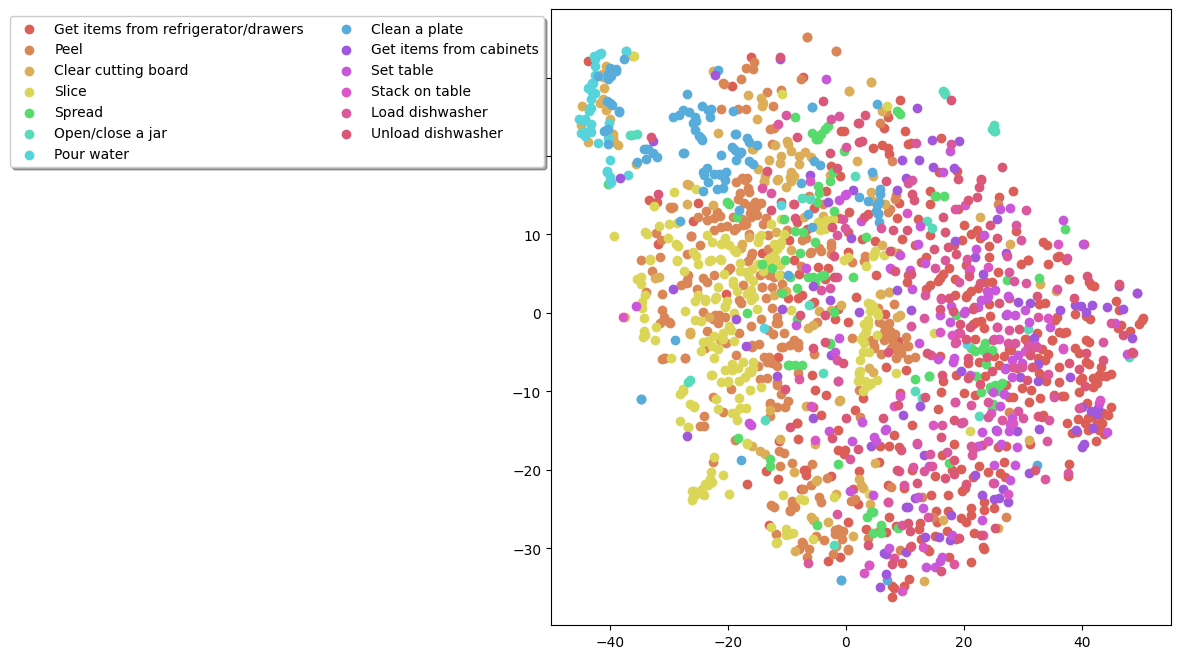

In [ ]:
import pickle
import numpy as np # type: ignore
from sklearn.cluster import KMeans # type: ignore
from sklearn.manifold import TSNE # type: ignore
import matplotlib.pyplot as plt # type: ignore
import pandas as pd # type: ignore
import seaborn as sns

#specify which labels should be changed to show the action
NEW_LABELS = {
    4:1,
    5:3,
    6:3,
    8:7,
    12:11,
    13:11,
    14:11
}

#old name of labels (shorter) + name for new labels
LABELS_NAME = {
    0: 'Get items from refrigerator/drawers',
    1:'Peel',
    2:'Clear cutting board',
    3:'Slice',
    7:'Spread',
    9:'Open/close a jar',
    10:'Pour water',
    11:'Clean a plate',
    15:'Get items from cabinets',
    16:'Set table',
    17:'Stack on table',
    18:'Load dishwasher',
    19:'Unload dishwasher',
}

COLORS = {
    i : x for i, x in enumerate(sns.color_palette("hls", max(LABELS_NAME.keys())+1).as_hex())
}

file_path = './an_data/EMG_saved_features/ActionNet_train.pkl'

with open(file_path, 'rb') as f:
    data = pickle.load(f)['features']

data = pd.DataFrame(data)

data['label'] = data.apply(lambda row: NEW_LABELS[row.label] if row.label in NEW_LABELS.keys() else row.label,
                           axis=1)

num_clusters = len(LABELS_NAME)
modality='EMG'

feature_vectors = [np.mean(video,axis=0) for video in data[f'features_{modality}']]

# Initialize K-Means clustering
kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init='auto')
cluster_labels = kmeans.fit_predict(feature_vectors)
data['cluster'] = cluster_labels

reduced = None
reduced = TSNE(n_components=2, learning_rate="auto", random_state=0, verbose=0, init = "pca", ).fit_transform(np.array(feature_vectors))

data['x'] = reduced[:, 0]
data['y'] = reduced[:, 1]

plt.figure(figsize=(8, 8))

for i in LABELS_NAME.keys():
    filtered = data[data['label'] == i]
    plt.scatter(filtered['x'], filtered['y'], c=COLORS[i], label=LABELS_NAME[i])


plt.legend(loc='upper right', bbox_to_anchor=(0, 1),
          ncol=2, fancybox=True, shadow=True)

plt.show()

plt.close()

# extract frames from the video

In [ ]:
!mkdir -p ./an_data/RGB/frames_indices
!mkdir -p ./an_data/RGB/frames

In [ ]:
# Mount google drive
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import pandas as pd
import math
import pickle
import numpy as np

def start_frame(row):
    #get first reading from both arm, convert it to a frame
    min_timestamp = min(row.myo_left_timestamps[0], row.myo_right_timestamps[0])
    frame = int((min_timestamp-START_TIME)*30)
    return frame

def stop_frame(row):
  #get last reading from both arm, convert it to a frame
  max_timestamp = max(row.myo_left_timestamps[-1], row.myo_right_timestamps[-1])
  frame = int((max_timestamp-START_TIME)*30)
  return frame

START_TIME = pd.read_pickle('./an_data/EMG/S04_1.pkl').iloc[0].start

union_indices = set() #used to save all distinct frames

for split in ['train', 'test']:
  emg = pd.read_pickle('./an_data/EMG_preprocessed/ActionNet_EMG_' + split + '.pkl')
  emg_s04 = emg[emg['subject_id']=='S04'].sort_values(by=['start'])

  emg_s04['start_frame'] = emg_s04.apply(lambda row: start_frame(row), axis=1)
  emg_s04['stop_frame'] = emg_s04.apply(lambda row: stop_frame(row), axis=1)

  #we can now attach to each row an array containing the indexes of the frames
  #based on EK we can use dense sampling with 10 frames
  emg_s04['index_frames'] = np.nan
  emg_s04['index_frames'] = emg_s04['index_frames'].astype(object)

  #dense sampling, 10 frames
  for i, _ in emg_s04.iterrows():
    center = int((emg_s04.loc[i, 'stop_frame'] - emg_s04.loc[i, 'start_frame'])/2 + emg_s04.loc[i, 'start_frame'])

    start = max(emg_s04.loc[i, 'start_frame'], center - math.ceil(10))
    end = min(emg_s04.loc[i, 'stop_frame'], center + math.ceil(10))
    emg_s04.at[i, 'index_frames'] = np.array(list(range(start, end, 2)))

    union_indices.update(emg_s04.at[i, 'index_frames']) #add it to the needed frames

  with open('./an_data/RGB/frames_indices/ActionNet_EMG_' + split + '.pkl', 'wb') as f_pickle:
    pickle.dump(emg_s04, f_pickle)

union_array = np.array(list(union_indices))
with open('./an_data/RGB/frames_indices/union_indices.pkl', 'wb') as f_pickle:
    pickle.dump(union_array, f_pickle)

In [ ]:
## Due to the size of video (around 20GB) the following code was run locally to avoid uploading files

#for extracting the frames from the video
!ffmpeg -i ./S04_video.mp4 -vf "fps=30,scale=456:256" -q:v 2 ./frames/frame_%010d.jpg

#by using all the frames indices select the frames we need
import pickle
import shutil

def copy_image(src_path, dest_path):
    shutil.copy(src_path, dest_path)


with open('C:\\Users\\nonlo\\OneDrive\\Desktop\\ActionNet_EMG\\frames\\union_indices.pkl', 'rb') as f:
    indices = pickle.load(f)

starting_folder = 'C:\\Users\\nonlo\\OneDrive\\Desktop\\frames'
target_folder = 'C:\\Users\\nonlo\\OneDrive\\Desktop\\selected_frames'

for i in indices:
    frame_path = starting_folder + '\\frame_' + str(i).zfill(10) + '.jpg'
    ending_path = target_folder + '\\frame_' + str(i).zfill(10) + '.jpg'
    copy_image(frame_path, target_folder)

In [ ]:
%%bash

# As read and write operations from google drive are slow, we suggest to copy and unzip
# the dataset in a local directory on the Colab's machine.
mkdir -p an_data/RGB/frames

# Copy the *.tar.gz files of Epic-Kitchens
cp -r "./drive/MyDrive/selected_frames.zip" ./an_data/RGB/frames

unzip "./an_data/RGB/frames/selected_frames.zip" -d "./an_data/RGB/frames"
rm "./an_data/RGB/frames/selected_frames.zip"  # Remove the original .zip file after extraction

Archive:  ./an_data/RGB/frames/selected_frames.zip
  inflating: ./an_data/RGB/frames/selected_frames/frame_0000025945.jpg  
  inflating: ./an_data/RGB/frames/selected_frames/frame_0000025947.jpg  
  inflating: ./an_data/RGB/frames/selected_frames/frame_0000025949.jpg  
  inflating: ./an_data/RGB/frames/selected_frames/frame_0000025951.jpg  
  inflating: ./an_data/RGB/frames/selected_frames/frame_0000025953.jpg  
  inflating: ./an_data/RGB/frames/selected_frames/frame_0000025955.jpg  
  inflating: ./an_data/RGB/frames/selected_frames/frame_0000025957.jpg  
  inflating: ./an_data/RGB/frames/selected_frames/frame_0000025959.jpg  
  inflating: ./an_data/RGB/frames/selected_frames/frame_0000025961.jpg  
  inflating: ./an_data/RGB/frames/selected_frames/frame_0000025963.jpg  
  inflating: ./an_data/RGB/frames/selected_frames/frame_0000026278.jpg  
  inflating: ./an_data/RGB/frames/selected_frames/frame_0000026280.jpg  
  inflating: ./an_data/RGB/frames/selected_frames/frame_0000026282.jpg  


In [ ]:
!mkdir -p ./an_data/RGB/features

In [ ]:
!cp -r "./drive/MyDrive/saved_models/"* ./aml23-ego/saved_models

In [ ]:
%%bash

cd aml23-ego

for split in 'train' 'test'; do

  python save_feat_rgb.py \
    config=configs/save_feat_rgb.yaml \
    name=$split split=$split
done

2024-06-14 10:27:18 LOG INFO Feature Extraction
2024-06-14 10:27:18 LOG INFO Running with parameters: 
  action: save
  name: train
  modality: ['RGB']
  total_batch: 128
  batch_size: 32
  gpus: None
  wandb_name: RGB_fe
  resume_from: ./saved_models/I3D_SourceOnlyD1
  logname: save_S04-S04.log
  models_dir: saved_models/train/Jun14_10-27-14
  train:
    num_iter: 5000
    lr_steps: 3000
    eval_freq: 50
    num_clips: 1
    dense_sampling:
      RGB: True
      EMG: False
    num_frames_per_clip:
      RGB: 16
      EMG: 32
    embedding_size: 1024
  test:
    num_clips: 1
    dense_sampling:
      RGB: True
      EMG: False
    num_frames_per_clip:
      RGB: 16
      EMG: 32
  dataset:
    annotations_path: ../an_data/RGB/frames_indices
    shift: S04-S04
    workers: 4
    stride: 1
    resolution: 224
    RGB:
      data_path: ../an_data/RGB/frames/selected_frames
      tmpl: img_{:010d}.jpg
      features_name: test_feat_kinetics
    Event:
      rgb4e: 6
    num_classes: 20
  

## Print features of RGB

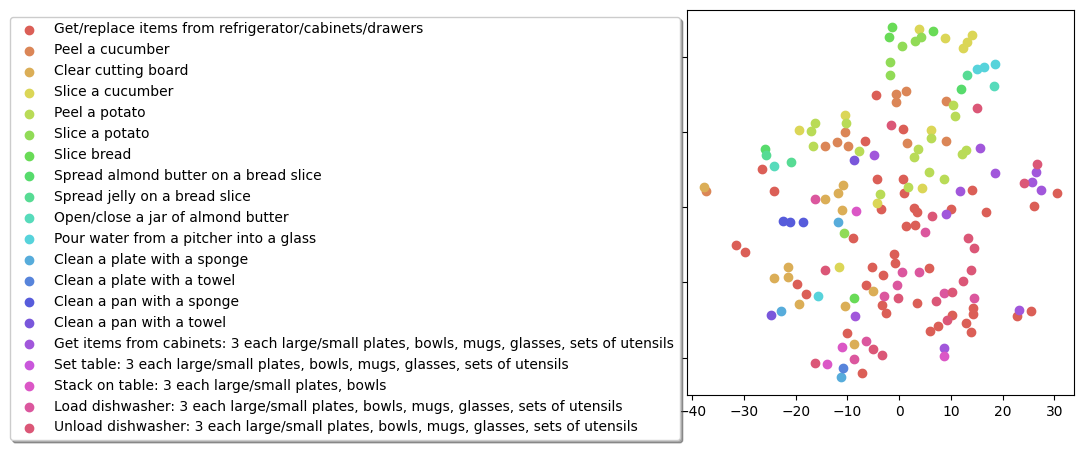

In [ ]:
import pickle
import numpy as np # type: ignore
from sklearn.cluster import KMeans # type: ignore
from sklearn.manifold import TSNE # type: ignore
import matplotlib.pyplot as plt # type: ignore
import pandas as pd # type: ignore
import seaborn as sns

#test of features by plotting

activities_to_classify = [
  'Get/replace items from refrigerator/cabinets/drawers',
  'Peel a cucumber',
  'Clear cutting board',
  'Slice a cucumber',
  'Peel a potato',
  'Slice a potato',
  'Slice bread',
  'Spread almond butter on a bread slice',
  'Spread jelly on a bread slice',
  'Open/close a jar of almond butter',
  'Pour water from a pitcher into a glass',
  'Clean a plate with a sponge',
  'Clean a plate with a towel',
  'Clean a pan with a sponge',
  'Clean a pan with a towel',
  'Get items from cabinets: 3 each large/small plates, bowls, mugs, glasses, sets of utensils',
  'Set table: 3 each large/small plates, bowls, mugs, glasses, sets of utensils',
  'Stack on table: 3 each large/small plates, bowls',
  'Load dishwasher: 3 each large/small plates, bowls, mugs, glasses, sets of utensils',
  'Unload dishwasher: 3 each large/small plates, bowls, mugs, glasses, sets of utensils',
  ]


COLORS = {
    i : x for i, x in enumerate(sns.color_palette("hls", 20).as_hex())
}

file_path = './an_data/RGB/features/ActionNet_train.pkl'

with open(file_path, 'rb') as f:
    data = pickle.load(f)['features']

data = pd.DataFrame(data)

with open('./an_data/EMG_preprocessed/ActionNet_EMG_train.pkl', 'rb') as f:
    emg_data = pickle.load(f)

emg_data = pd.DataFrame(emg_data)

emg_data_s04 = emg_data[emg_data['subject_id']=='S04']

merged = data.merge(emg_data_s04, left_on='id', right_on='id')

merged['label'] = merged.apply(lambda row: NEW_LABELS[row.description] if row.description in NEW_LABELS.keys() else row.description,
                           axis=1)

num_clusters = len(LABELS_NAME)
modality='RGB'

feature_vectors = [video for video in merged[f'features_{modality}']]

reduced = None
reduced = TSNE(n_components=2, learning_rate="auto", random_state=0, verbose=0, init = "pca", perplexity=5).fit_transform(np.array(feature_vectors))

merged['x'] = reduced[:, 0]
merged['y'] = reduced[:, 1]

plt.figure(figsize=(5, 5))

for idx in range(len(activities_to_classify)):
    filtered = merged[merged['description'] == idx]
    plt.scatter(filtered['x'], filtered['y'], c=COLORS[idx], label=activities_to_classify[idx])


plt.legend(loc='upper right', bbox_to_anchor=(0, 1),
          ncol=1, fancybox=True, shadow=True)

plt.show()

plt.close()

# Train VAE

In [ ]:
!mkdir -p ./aml23-ego/saved_features/reconstructed_RGB
!mkdir -p ./aml23-ego/saved_models/VAE_RGB

In [ ]:
%%bash

cd aml23-ego

python train_VAE_RGB.py action="train"  name="VAE_FT_D_10f"   config=configs/rgb_vae.yaml

[1/100] - Total loss: 7.680168479681015
[2/100] - Total loss: 2.857774496078491
[3/100] - Total loss: 2.6346751637756824
[4/100] - Total loss: 2.565942756831646
[5/100] - Total loss: 2.497043836861849
[6/100] - Total loss: 2.4682677164673805
[7/100] - Total loss: 2.439759511500597
[8/100] - Total loss: 2.40923934802413
[9/100] - Total loss: 2.3944513984024525
[10/100] - Total loss: 2.35542019456625
[11/100] - Total loss: 2.329695202410221
[12/100] - Total loss: 2.299285888671875
[13/100] - Total loss: 2.3081764057278633
[14/100] - Total loss: 2.2802989445626736
[15/100] - Total loss: 2.239368487149477
[16/100] - Total loss: 2.235461086034775
[17/100] - Total loss: 2.2086851000785828
[18/100] - Total loss: 2.180059142410755
[19/100] - Total loss: 2.1711762994527817
[20/100] - Total loss: 2.1510092057287693
[21/100] - Total loss: 2.1272580064833164
[22/100] - Total loss: 2.123272866010666
[23/100] - Total loss: 2.117155808955431
[24/100] - Total loss: 2.096133556216955
[25/100] - Total l

2024-06-14 10:28:51 LOG INFO Running with parameters: 
  action: train
  name: VAE_FT_D_10f
  modality: ['RGB']
  total_batch: 128
  batch_size: 32
  gpus: None
  wandb_name: RGB-VAE
  resume_from: None
  logname: None
  models_dir: saved_models/VAE_FT_D_10f/Jun14_10-28-40
  train:
    num_iter: 300
    lr_steps: 50
    eval_freq: 50
    num_clips: 5
    dense_sampling:
      RGB: True
    num_frames_per_clip:
      RGB: 5
    RGB:
      feature_size: 1024
    bottleneck_size: 256
  test:
    num_clips: 5
    dense_sampling:
      RGB: True
    num_frames_per_clip:
      RGB: 5
  dataset:
    annotations_path: train_val
    shift: D1-D1
    workers: 4
    stride: 2
    resolution: 224
    RGB:
      data_path: ../ek_data/frames
      tmpl: img_{:010d}.jpg
      features_name: 10_dense_finetuned
    Event:
      rgb4e: 6
    num_classes: 12
  models:
    RGB:
      model: VariationalAutoencoder
      normalize: False
      kwargs:
      lr_steps: 30
      lr: 0.001
      sgd_momentum: 0

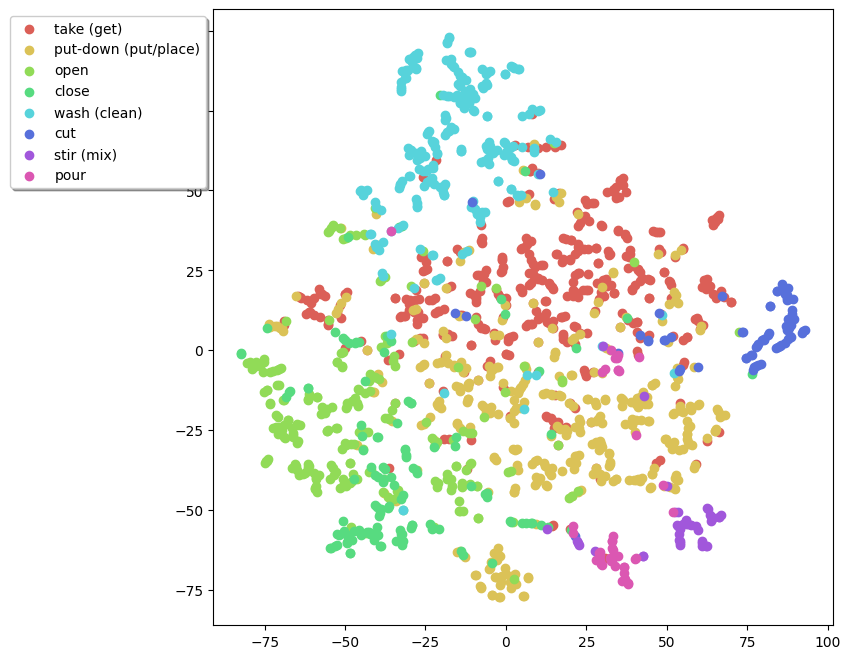

In [ ]:
import pickle
import numpy as np # type: ignore
from sklearn.cluster import KMeans # type: ignore
from sklearn.manifold import TSNE # type: ignore
import matplotlib.pyplot as plt # type: ignore
import pandas as pd # type: ignore
import seaborn as sns

file_path = './aml23-ego/saved_features/reconstructed_RGB/ActionNet_train.pkl'

with open(file_path, 'rb') as f:
    data = pickle.load(f)['features']

data = pd.DataFrame(data)

feature_vectors = [np.mean(video, axis=0) for video in data[f'features_RGB']]

reduced = None
reduced = TSNE(n_components=2, learning_rate="auto", random_state=0, verbose=0, init = "pca", perplexity=5).fit_transform(np.array(feature_vectors))

data['x'] = reduced[:, 0]
data['y'] = reduced[:, 1]

COLORS = {
    i : x for i, x in enumerate(sns.color_palette("hls", 8).as_hex())
}

LABELS = {
        0 : "take (get)",
        1 : "put-down (put/place)",
        2 : "open",
        3 : "close",
        4 : "wash (clean)",
        5 : "cut",
        6 : "stir (mix)",
        7 : "pour"
}


plt.figure(figsize=(8, 8))

for act in range(8):
    filtered = data[data['label'] == act]
    plt.scatter(filtered['x'], filtered['y'], c=COLORS[act], label=LABELS[act])


plt.legend(loc='upper right', bbox_to_anchor=(0, 1),
          ncol=1, fancybox=True, shadow=True)

plt.show()

plt.close()

In [ ]:
!mkdir -p ./aml23-ego/saved_features/reconstructed_EMG
!mkdir -p ./aml23-ego/saved_models/VAE_EMG

In [ ]:
%%bash

cd aml23-ego

python train_VAE_EMG.py action="train"  name="VAE_FT_D_10f"   config=configs/emg_vae.yaml

[1/100] - Total loss: 420.32963514328003
[2/100] - Total loss: 197.28940343856812
[3/100] - Total loss: 154.1688883304596
[4/100] - Total loss: 140.79046487808228
[5/100] - Total loss: 131.19509506225586
[6/100] - Total loss: 123.66080129146576
[7/100] - Total loss: 116.47820782661438
[8/100] - Total loss: 109.91361927986145
[9/100] - Total loss: 105.14933609962463
[10/100] - Total loss: 100.73478841781616
[11/100] - Total loss: 96.78831505775452
[12/100] - Total loss: 94.06623554229736
[13/100] - Total loss: 91.83131444454193
[14/100] - Total loss: 90.05710637569427
[15/100] - Total loss: 86.95751488208771
[16/100] - Total loss: 83.32091569900513
[17/100] - Total loss: 81.98872065544128
[18/100] - Total loss: 79.31603562831879
[19/100] - Total loss: 77.87037992477417
[20/100] - Total loss: 76.17005693912506
[21/100] - Total loss: 74.97027575969696
[22/100] - Total loss: 73.13939154148102
[23/100] - Total loss: 71.31801199913025
[24/100] - Total loss: 69.58201920986176
[25/100] - Total

2024-06-14 10:33:25 LOG INFO Running with parameters: 
  action: train
  name: VAE_FT_D_10f
  modality: ['EMG']
  total_batch: 128
  batch_size: 32
  gpus: None
  wandb_name: EMG-VAE
  resume_from: None
  logname: None
  models_dir: saved_models/VAE_FT_D_10f/Jun14_10-33-21
  train:
    num_iter: 300
    lr_steps: 50
    eval_freq: 50
    num_clips: 5
    dense_sampling:
      RGB: True
    num_frames_per_clip:
      RGB: 5
    EMG:
      feature_size: 1664
    bottleneck_size: 256
  test:
    num_clips: 5
    dense_sampling:
      RGB: True
    num_frames_per_clip:
      RGB: 5
  dataset:
    annotations_path: ../an_data/EMG_preprocessed/
    shift: D1-D1
    workers: 4
    stride: 2
    resolution: 224
    RGB:
      data_path: None
      tmpl: img_{:010d}.jpg
      features_name: test_feat_kinetics
    Event:
      rgb4e: 6
    num_classes: 20
    EMG:
      data_path: ../an_data/EMG_saved_features/
  models:
    RGB:
      model: Classifier
      normalize: False
      kwargs:
     

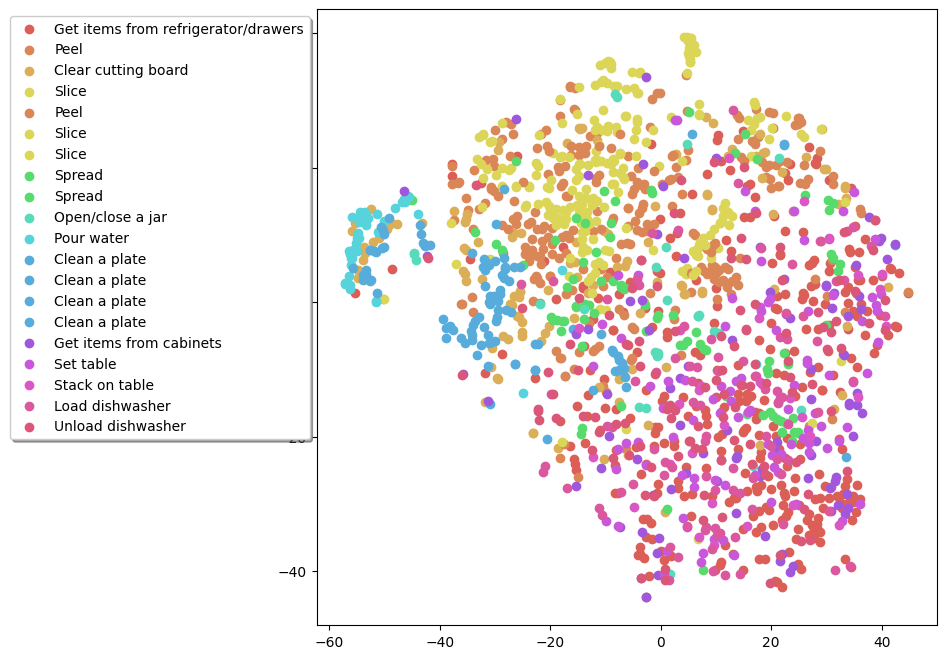

In [ ]:
import pickle
import numpy as np # type: ignore
from sklearn.cluster import KMeans # type: ignore
from sklearn.manifold import TSNE # type: ignore
import matplotlib.pyplot as plt # type: ignore
import pandas as pd # type: ignore
import seaborn as sns

file_path = './aml23-ego/saved_features/reconstructed_EMG/ActionNet_train.pkl'

with open(file_path, 'rb') as f:
    data = pickle.load(f)['features']

data = pd.DataFrame(data)

feature_vectors = [np.mean(video, axis=0) for video in data[f'features_EMG']]

reduced = None
reduced = TSNE(n_components=2, learning_rate="auto", random_state=0, verbose=0, init = "pca",).fit_transform(np.array(feature_vectors))

data['x'] = reduced[:, 0]
data['y'] = reduced[:, 1]

COLORS = {
    i : x for i, x in enumerate(sns.color_palette("hls", 20).as_hex())
}

LABELS = {
    0: 'Get items from refrigerator/drawers',
    1:'Peel',
    2:'Clear cutting board',
    3:'Slice',
    7:'Spread',
    9:'Open/close a jar',
    10:'Pour water',
    11:'Clean a plate',
    15:'Get items from cabinets',
    16:'Set table',
    17:'Stack on table',
    18:'Load dishwasher',
    19:'Unload dishwasher',
}

NEW_LABELS = {
    4:1,
    5:3,
    6:3,
    8:7,
    12:11,
    13:11,
    14:11
}


plt.figure(figsize=(8, 8))

for act in range(20):
    filtered = data[data['label'] == act]
    if act in NEW_LABELS:
      act = NEW_LABELS[act]
    plt.scatter(filtered['x'], filtered['y'], c=COLORS[act], label=LABELS[act])


plt.legend(loc='upper right', bbox_to_anchor=(0, 1),
          ncol=1, fancybox=True, shadow=True)

plt.show()

plt.close()

In [ ]:
!mkdir -p ./aml23-ego/saved_features/reconstructed_EMG_S04
!mkdir -p ./aml23-ego/saved_models/VAE_RGB_EMG

In [ ]:
%%bash

cd aml23-ego

python train_VAE_s04.py action="train"  name="VAE_FT_D_10f"   config=configs/emg_rgb_vae.yaml

[1/100] - Total loss: 41.82284879684448
[2/100] - Total loss: 36.0937123298645
[3/100] - Total loss: 31.823965072631836
[4/100] - Total loss: 27.97659397125244
[5/100] - Total loss: 26.672743797302246
[6/100] - Total loss: 25.737730979919434
[7/100] - Total loss: 25.39615821838379
[8/100] - Total loss: 24.408977031707764
[9/100] - Total loss: 24.06017303466797
[10/100] - Total loss: 23.07128667831421
[11/100] - Total loss: 22.60438108444214
[12/100] - Total loss: 22.350292682647705
[13/100] - Total loss: 22.133387088775635
[14/100] - Total loss: 21.354623794555664
[15/100] - Total loss: 21.25327968597412
[16/100] - Total loss: 20.194713592529297
[17/100] - Total loss: 20.054211139678955
[18/100] - Total loss: 19.391589164733887
[19/100] - Total loss: 18.96326494216919
[20/100] - Total loss: 18.79387927055359
[21/100] - Total loss: 18.160974264144897
[22/100] - Total loss: 18.01966094970703
[23/100] - Total loss: 17.568914651870728
[24/100] - Total loss: 16.940459728240967
[25/100] - To

2024-06-14 10:36:16 LOG INFO Running with parameters: 
  action: train
  name: VAE_FT_D_10f
  modality: ['EMG', 'RGB']
  total_batch: 128
  batch_size: 32
  gpus: None
  wandb_name: EMG-RGB-VAE
  resume_from: ./saved_models/I3D_SourceOnlyD1
  logname: None
  models_dir: saved_models/VAE_FT_D_10f/Jun14_10-36-11
  train:
    num_iter: 300
    lr_steps: 50
    eval_freq: 50
    num_clips: 5
    dense_sampling:
      RGB: True
    num_frames_per_clip:
      RGB: 5
    EMG:
      feature_size: 1664
    RGB:
      feature_size: 1024
    bottleneck_size: 256
  test:
    num_clips: 5
    dense_sampling:
      RGB: True
    num_frames_per_clip:
      RGB: 5
  dataset:
    annotations_path: ../an_data/EMG_preprocessed/
    shift: S04-S04
    workers: 4
    stride: 2
    resolution: 224
    RGB:
      data_path: ../an_data/RGB/features
      tmpl: img_{:010d}.jpg
      features_name: 10_dense_finetuned
    Event:
      rgb4e: 6
    num_classes: 20
    EMG:
      data_path: ../an_data/EMG_saved_fe

In [ ]:
!mkdir -p ./aml23-ego/saved_features/reconstructed_EMG_Epic

In [ ]:
%%bash

cd aml23-ego

##need a new one for resume_from and EK
python train_VAE_s04.py action="reconstruct"  name="VAE_FT_D_10f"   config=configs/VAE_Epic.yaml

2024-06-14 10:37:02 LOG INFO Running with parameters: 
  action: reconstruct
  name: VAE_FT_D_10f
  modality: ['RGB']
  total_batch: 128
  batch_size: 32
  gpus: None
  wandb_name: RGB-sEMG
  resume_from: saved_models/VAE_FT_D_10f/Jun14_10-36-58/VAE_FT_D_10f
  logname: reconstruct_D1-D1.log
  models_dir: saved_models/VAE_FT_D_10f/Jun14_10-36-58
  train:
    num_iter: 200
    lr_steps: 50
    eval_freq: 50
    num_clips: 10
    dense_sampling:
      RGB: True
    num_frames_per_clip:
      RGB: 5
    EMG:
      feature_size: 1664
    RGB:
      feature_size: 1024
    bottleneck_size: 256
  test:
    num_clips: 5
    dense_sampling:
      RGB: True
    num_frames_per_clip:
      RGB: 5
  dataset:
    annotations_path: train_val
    shift: D1-D1
    workers: 4
    stride: 2
    resolution: 224
    RGB:
      data_path: ../ek_data/frames
      tmpl: img_{:010d}.jpg
      features_name: 10_dense_finetuned
    Event:
      rgb4e: 6
    num_classes: 20
  models:
    RGB:
      model: Classifi

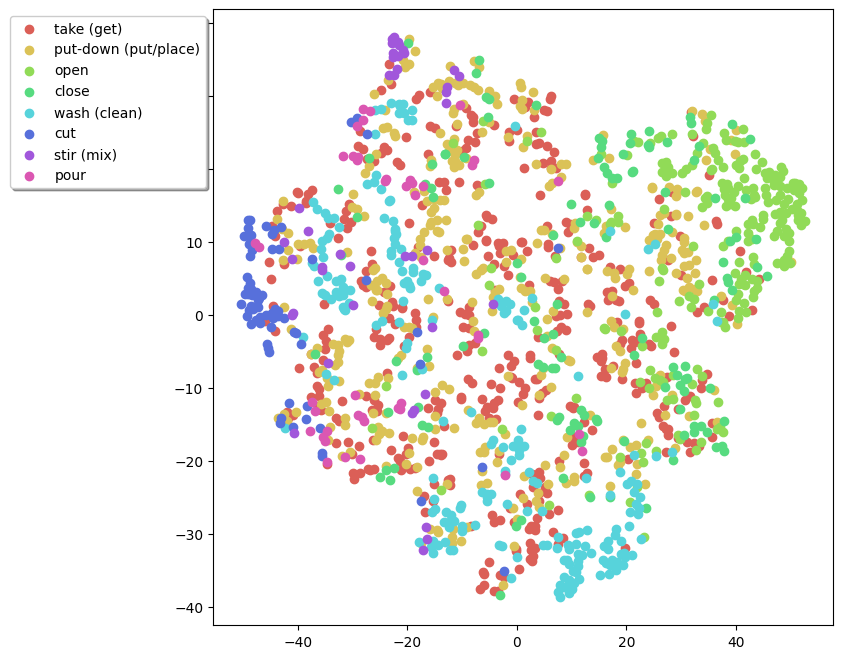

In [ ]:
import pickle
import numpy as np # type: ignore
from sklearn.cluster import KMeans # type: ignore
from sklearn.manifold import TSNE # type: ignore
import matplotlib.pyplot as plt # type: ignore
import pandas as pd # type: ignore
import seaborn as sns

file_path = './aml23-ego/extracted_features/ActionNet_D1_train.pkl'

with open(file_path, 'rb') as f:
    data = pickle.load(f)['features']

data = pd.DataFrame(data)

feature_vectors = [np.mean(video, axis=0) for video in data[f'features_EMG']]

reduced = None
reduced = TSNE(n_components=2, learning_rate="auto", random_state=0, verbose=0, init = "pca",).fit_transform(np.array(feature_vectors))

data['x'] = reduced[:, 0]
data['y'] = reduced[:, 1]

COLORS = {
    i : x for i, x in enumerate(sns.color_palette("hls", 8).as_hex())
}
LABELS = {
        0 : "take (get)",
        1 : "put-down (put/place)",
        2 : "open",
        3 : "close",
        4 : "wash (clean)",
        5 : "cut",
        6 : "stir (mix)",
        7 : "pour"
}


plt.figure(figsize=(8, 8))

for act in range(8):
    filtered = data[data['label'] == act]
    plt.scatter(filtered['x'], filtered['y'], c=COLORS[act], label=LABELS[act])


plt.legend(loc='upper right', bbox_to_anchor=(0, 1),
          ncol=1, fancybox=True, shadow=True)

plt.show()

plt.close()

In [ ]:
%%bash

cd aml23-ego

#specify feature extraction
frames_per_clip=10
mod_sampling='dense'
model='finetuned'

python train_classifier_TRN.py config=configs/train_classifier.yaml \
  models.EMG.model='TRN' action='train' \
  modality=['EMG'] \
  dataset.EMG.features_name="ActionNet" \
  train.num_iter=1750 \
  train.dense_sampling.RGB=${dense_sampling} \
  train.num_clips=5 \
  test.num_clips=5

Multi-Scale Temporal Relation with classifier in use
['5-frame relation', '4-frame relation', '3-frame relation', '2-frame relation']


2024-06-14 10:42:13 LOG INFO Running with parameters: 
  action: train
  name: saved_feat_I3D
  modality: ['EMG']
  total_batch: 128
  batch_size: 32
  gpus: None
  wandb_name: None
  resume_from: None
  logname: None
  models_dir: saved_models/saved_feat_I3D/Jun14_10-42-09
  train:
    num_iter: 1750
    lr_steps: 3000
    eval_freq: 50
    num_clips: 5
    dense_sampling:
      RGB: None
    num_frames_per_clip:
      RGB: 5
  test:
    num_clips: 5
    dense_sampling:
      RGB: True
    num_frames_per_clip:
      RGB: 5
  dataset:
    annotations_path: train_val
    shift: D1-D1
    workers: 4
    stride: 2
    resolution: 224
    RGB:
      data_path: ../ek_data/frames
      tmpl: img_{:010d}.jpg
      features_name: test_feat_kinetics
    Event:
      rgb4e: 6
    num_classes: 8
    EMG:
      features_name: ActionNet
  models:
    RGB:
      model: I3D
      normalize: False
      kwargs:
      lr_steps: 3000
      lr: 0.005
      sgd_momentum: 0.9
      weight_decay: 1e-07
    

In [ ]:
%%bash

cd aml23-ego

#specify feature extraction
frames_per_clip=10
mod_sampling='dense'
model='finetuned'

python train_classifier_TRN.py config=configs/train_classifier.yaml \
  models.EMG.model='ActionLSTM' models.RGB.model='TRN' action='train' \
  modality=['RGB','EMG'] \
  dataset.EMG.features_name="ActionNet" \
  dataset.RGB.features_name="10_dense_finetuned" \
  train.num_iter=1750 \
  train.dense_sampling.RGB=${dense_sampling} \
  train.num_clips=5 \
  test.num_clips=5 \
  #train.num_frames_per_clip=${frames_per_clip} \
  #test.num_frames_per_clip=${frames_per_clip}

Multi-Scale Temporal Relation with classifier in use
['5-frame relation', '4-frame relation', '3-frame relation', '2-frame relation']


2024-06-13 17:40:51 LOG INFO Running with parameters: 
  action: train
  name: saved_feat_I3D
  modality: ['RGB', 'EMG']
  total_batch: 128
  batch_size: 32
  gpus: None
  wandb_name: None
  resume_from: None
  logname: None
  models_dir: saved_models/saved_feat_I3D/Jun13_17-40-47
  train:
    num_iter: 1750
    lr_steps: 3000
    eval_freq: 50
    num_clips: 5
    dense_sampling:
      RGB: None
    num_frames_per_clip:
      RGB: 5
  test:
    num_clips: 5
    dense_sampling:
      RGB: True
    num_frames_per_clip:
      RGB: 5
  dataset:
    annotations_path: train_val
    shift: D1-D1
    workers: 4
    stride: 2
    resolution: 224
    RGB:
      data_path: ../ek_data/frames
      tmpl: img_{:010d}.jpg
      features_name: 10_dense_finetuned
    Event:
      rgb4e: 6
    num_classes: 8
    EMG:
      features_name: ActionNet
  models:
    RGB:
      model: TRN
      normalize: False
      kwargs:
      lr_steps: 3000
      lr: 0.001
      sgd_momentum: 0.9
      weight_decay: 1e-